# Max_length Sub Testing

### Results:


| Max Length | Test Accuracy | Negative Precision | Negative Recall | Neutral Precision | Neutral Recall | Positive Precision | Positive Recall | Confusion Matrix Highlights | Loss/Accuracy Behavior | Notes |
|:-----------|:--------------|:-------------------|:----------------|:------------------|:---------------|:-------------------|:----------------|:----------------------------|:----------------------|:------|
| 512        | ~83%           | 1.00                | 0.40             | 0.96               | 0.94            | 0.66                | 0.93             | Very low Negative recall; Negatives misclassified. | Some overfitting; validation loss fluctuates. | Baseline. |
| 256        | ~87%           | 0.69                | 0.67             | 0.96               | 0.96            | 0.75                | 0.75             | Much better Negative coverage, Neutral stable. | Training/validation curves very steady. | **Best overall**. |
| 128        | ~87%           | 0.68                | 0.83             | 0.96               | 0.96            | 0.79                | 0.69             | Slight more Positive/Neutral confusion. | Less stable than 256, slightly noisier. | Still good, 2nd place. |
| 64         | ~85%           | 0.92                | 0.40             | 0.96               | 0.93            | 0.65                | 0.91             | Negative recall collapses; Positive confusion rises. | Validation loss struggles again. | Poor generalization. |

---

Testing different `max_length` values revealed **256 tokens** offers the best tradeoff between precision, recall, and model stability.

- **Accuracy** improves significantly from the 512 baseline, matching or exceeding the shorter 128 and 64 configurations.
- **Negative Class Recovery** is strong — overcoming the recall collapse seen in both 512 and 64 settings.
- **Neutral Class Robustness** remains consistent across settings, but 256 preserves it while keeping Positive class confusion manageable.
- **Training and Validation Curves** for 256 are notably smoother than for 128 or 64, indicating better generalization and less overfitting.

Thus, **256 tokens** is selected as the best configuration for downstream fine-tuning.

---


# Imports

In [1]:
!pip install transformers datasets scikit-learn pandas numpy tqdm tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

# Loading Model & Tokenizer

In [2]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset

# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# max_length = 512 (Benchmark)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 67s 197ms/step - loss: 0.5430 - accuracy: 0.7559 - val_loss: 0.5440 - val_accuracy: 0.7389
Epoch 2/3
227/227 [==============================] - 46s 201ms/step - loss: 0.4117 - accuracy: 0.8222 - val_loss: 0.3941 - val_accuracy: 0.8363
Epoch 3/3
29/29 [==============================] - 5s 152ms/step - loss: 0.3638 - accuracy: 0.8326
Test Loss: 0.3638, Test Accuracy: 0.8326


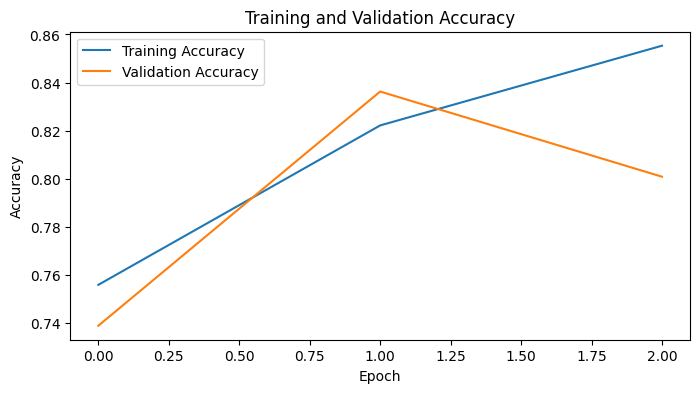

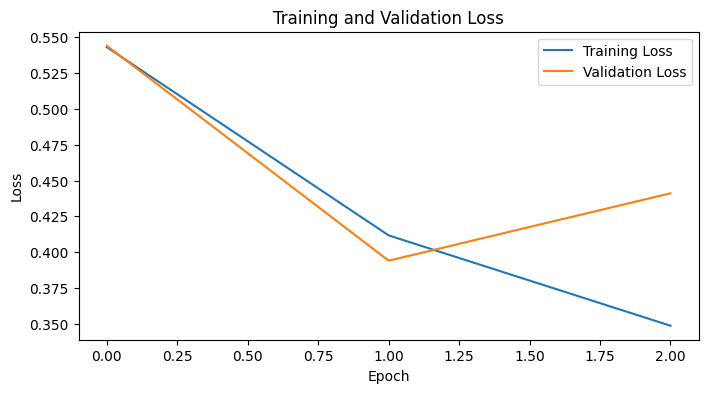

29/29 [==============================] - 6s 150ms/step
              precision    recall  f1-score   support

    Negative       1.00      0.23      0.38        30
     Neutral       0.96      0.93      0.94       142
    Positive       0.61      0.91      0.73        55

    accuracy                           0.83       227
   macro avg       0.86      0.69      0.68       227
weighted avg       0.88      0.83      0.82       227

[[  7   1  22]
 [  0 132  10]
 [  0   5  50]]


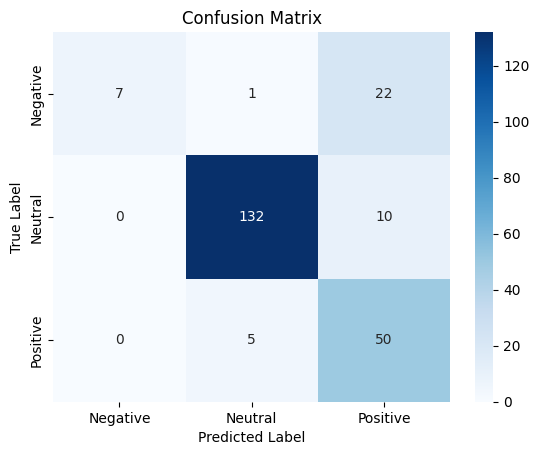

In [3]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze DistilBERT encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# max_length = 256

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 29s 100ms/step - loss: 0.5421 - accuracy: 0.7587 - val_loss: 0.4266 - val_accuracy: 0.8097
Epoch 2/3
227/227 [==============================] - 23s 101ms/step - loss: 0.3917 - accuracy: 0.8266 - val_loss: 0.4996 - val_accuracy: 0.7566
Epoch 3/3
29/29 [==============================] - 2s 73ms/step - loss: 0.3294 - accuracy: 0.8722
Test Loss: 0.3294, Test Accuracy: 0.8722


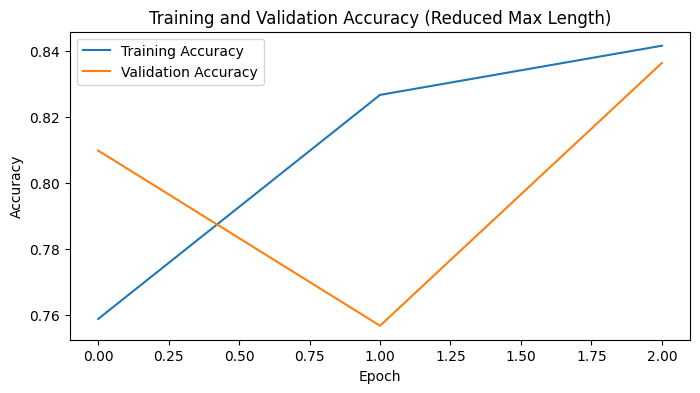

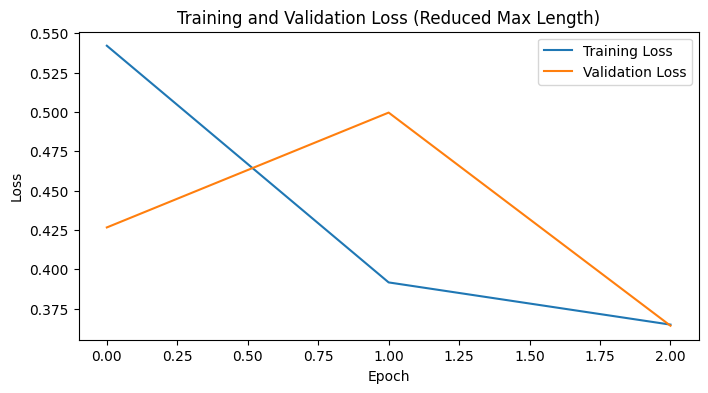

29/29 [==============================] - 3s 71ms/step
              precision    recall  f1-score   support

    Negative       0.69      0.67      0.68        30
     Neutral       0.96      0.96      0.96       142
    Positive       0.75      0.75      0.75        55

    accuracy                           0.87       227
   macro avg       0.80      0.79      0.79       227
weighted avg       0.87      0.87      0.87       227



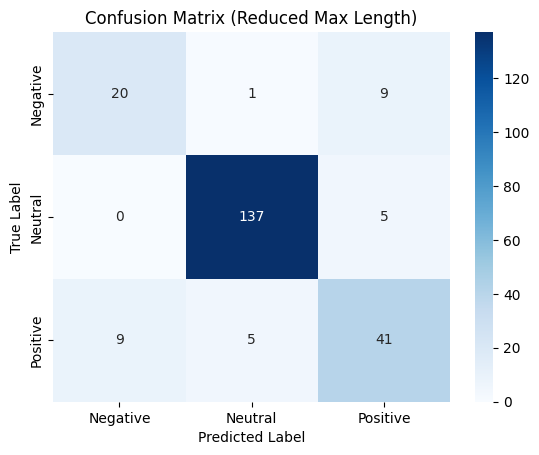

In [4]:
# Tokenization (new max_length=128)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets (same)
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (no class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Reduced Max Length)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# max_length = 128

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 18s 55ms/step - loss: 0.5552 - accuracy: 0.7482 - val_loss: 0.4410 - val_accuracy: 0.8142
Epoch 2/3
227/227 [==============================] - 11s 48ms/step - loss: 0.4045 - accuracy: 0.8211 - val_loss: 0.3879 - val_accuracy: 0.8186
Epoch 3/3
29/29 [==============================] - 1s 41ms/step - loss: 0.3297 - accuracy: 0.8722
Test Loss: 0.3297, Test Accuracy: 0.8722


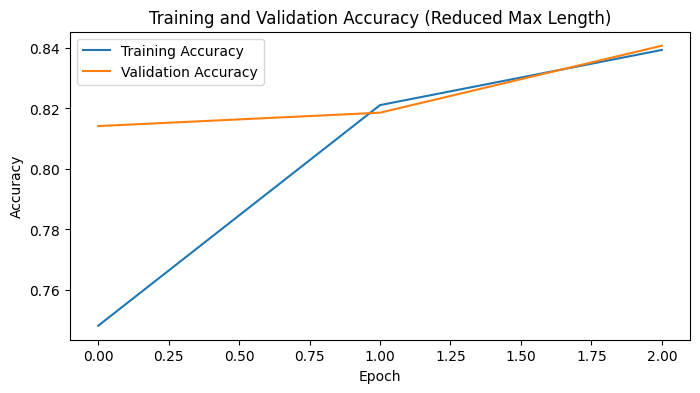

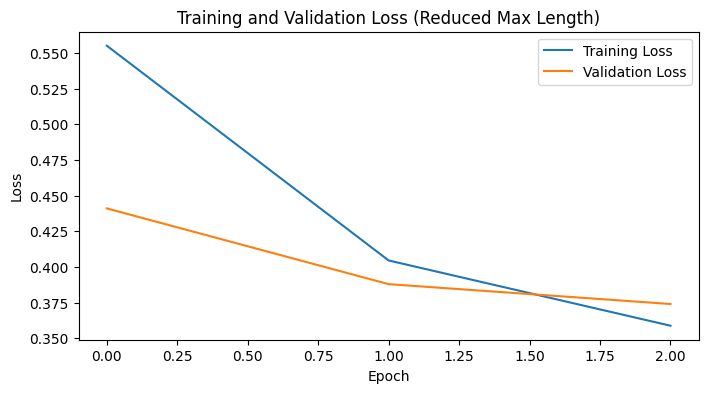

29/29 [==============================] - 2s 38ms/step
              precision    recall  f1-score   support

    Negative       0.89      0.57      0.69        30
     Neutral       0.96      0.93      0.95       142
    Positive       0.69      0.89      0.78        55

    accuracy                           0.87       227
   macro avg       0.85      0.80      0.81       227
weighted avg       0.89      0.87      0.87       227



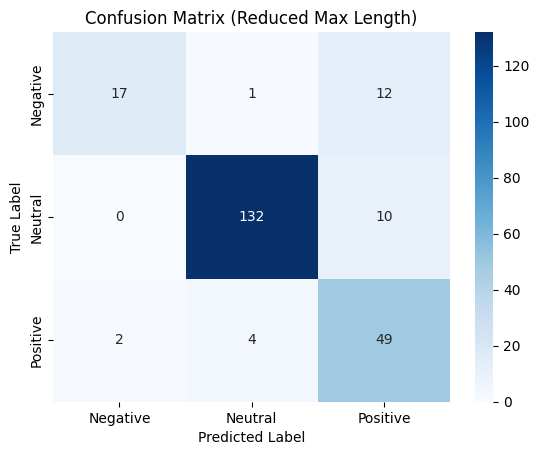

In [5]:
# Tokenization (new max_length=128)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets (same)
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (no class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Reduced Max Length)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# max_length = 64

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 15s 37ms/step - loss: 0.5654 - accuracy: 0.7526 - val_loss: 0.4522 - val_accuracy: 0.8009
Epoch 2/3
227/227 [==============================] - 7s 31ms/step - loss: 0.3970 - accuracy: 0.8283 - val_loss: 0.4676 - val_accuracy: 0.7876
Epoch 3/3
29/29 [==============================] - 1s 23ms/step - loss: 0.3351 - accuracy: 0.8546
Test Loss: 0.3351, Test Accuracy: 0.8546


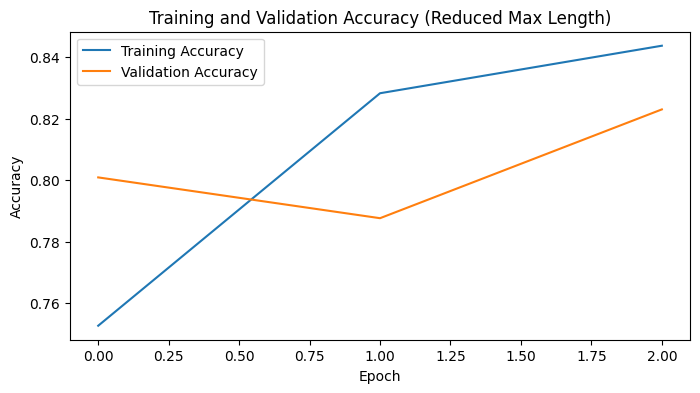

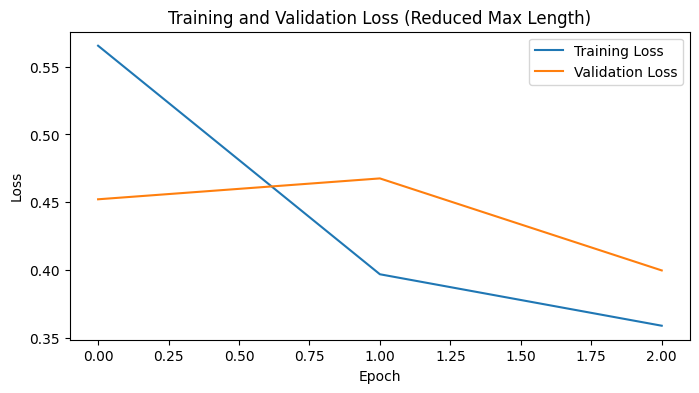

29/29 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

    Negative       0.92      0.40      0.56        30
     Neutral       0.96      0.93      0.95       142
    Positive       0.65      0.91      0.76        55

    accuracy                           0.85       227
   macro avg       0.85      0.75      0.75       227
weighted avg       0.88      0.85      0.85       227



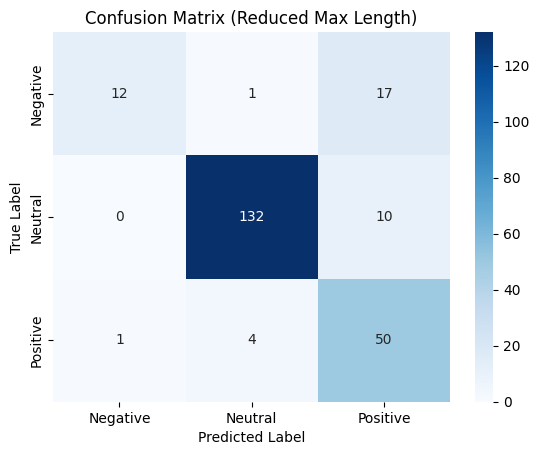

In [6]:
# Tokenization (new max_length=128)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets (same)
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (no class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Reduced Max Length)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()